In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import pdist
from sklearn.preprocessing import *
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split

torch.manual_seed(411)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Oct 08

Just use same basis tensors as 2body.

Oct 22: Solved the high error problem with angular velocity

In [2]:
root = "../data/multibody"
times1 = [f for f in os.listdir(root) if f.startswith("X_sphere_")]
times1 = set([(root, f[9:-4]) for f in times1])

root = "../data/multibody_new/"
times2 = [f for f in os.listdir(root) if f.startswith("X_sphere_")]
times2 = set([(root, f[9:-4]) for f in times2])

times = times1 | times2

xs, ys, counts = [], [], []
for root, file in times:
    x = np.load(f"{root}/X_sphere_{file}.npy", allow_pickle=True)
    y = np.load(f"{root}/Y_sphere_{file}.npy")
    cnts = np.load(f"{root}/neighbors_{file}.npy")
    xs.append(x)
    ys.append(y)
    counts.append(cnts)

X_ragged = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)
neighbor_counts = np.concatenate(counts, axis=0)

N = len(Y)
print(N)
MAX_NEIGHBORS=10

X = np.zeros((N,11+MAX_NEIGHBORS*3), dtype=np.float64)
for i in range(N):
    nk = neighbor_counts[i]
    X[i, 0:11+nk*3] = X_ragged[i].copy()

XY = np.hstack([X, Y])          # shape: (total_rows, 16)
print(XY.shape)

#sanity check
for i in range(N):
    nk = neighbor_counts[i]
    pos = np.zeros(((nk+2), 3), dtype=np.float64)
    pos[0] = np.zeros((3,)) #target
    pos[1] = X[i, :3] #src
    pos[2:,:] = X[i, 11:11+nk*3].reshape((nk, 3))
    dd = pdist(pos)
    assert np.all(dd>2.02)

s_cols = ["x_s", "y_s", "z_s", "dist_s", "min_dist_s", 
          "f_x_s", "f_y_s", "f_z_s", "tor_x_s", "tor_y_s", "tor_z_s"]
k_cols = []
for i in range(10):
    k_cols.append(f"x_k_{i}")
    k_cols.append(f"y_k_{i}")
    k_cols.append(f"z_k_{i}")
y_cols = ["vel_x", "vel_y", "vel_z", "angvel_x", "angvel_y", "angvel_z"]
column_names = s_cols + k_cols + y_cols

df = pd.DataFrame(XY, columns=column_names)

cols_to_move = ['dist_s', 'min_dist_s'] #move them to the end
new_cols = [col for col in df.columns if col not in cols_to_move] + cols_to_move
df = df[new_cols]

df.shape, df.columns

49400
(49400, 47)


((49400, 47),
 Index(['x_s', 'y_s', 'z_s', 'f_x_s', 'f_y_s', 'f_z_s', 'tor_x_s', 'tor_y_s',
        'tor_z_s', 'x_k_0', 'y_k_0', 'z_k_0', 'x_k_1', 'y_k_1', 'z_k_1',
        'x_k_2', 'y_k_2', 'z_k_2', 'x_k_3', 'y_k_3', 'z_k_3', 'x_k_4', 'y_k_4',
        'z_k_4', 'x_k_5', 'y_k_5', 'z_k_5', 'x_k_6', 'y_k_6', 'z_k_6', 'x_k_7',
        'y_k_7', 'z_k_7', 'x_k_8', 'y_k_8', 'z_k_8', 'x_k_9', 'y_k_9', 'z_k_9',
        'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y', 'angvel_z', 'dist_s',
        'min_dist_s'],
       dtype='object'))

In [3]:
np.abs(df[["vel_x", "vel_y", "vel_z"]].values).mean(), np.abs(df[["angvel_x", "angvel_y", "angvel_z"]].values).mean()


(0.12631818340661147, 0.02013145717466011)

In [4]:
mean_dist_s = df['dist_s'].mean()
df['dist_s'] -= mean_dist_s
df['dist_s_sq'] = df['dist_s']**2
df['dist_s_sqsq'] = df['dist_s_sq']**2

origin = np.array([0.0, 0.0, 0.0])
# df['x_s'] = origin[0] - df['x_s']
# df['y_s'] = origin[1] - df['y_s']
# df['z_s'] = origin[2] - df['z_s']

In [5]:
FEATURE_NAMES = ['r_sum','r_diff','r_prod','u_over_ell_abs',
                 'u_over_ell_sq','rho_over_ell','inv_sum',
                 'inv_prod','inv_absdiff','cos_k']

K: int = 10
eps: float = 1e-9

# --- s, t, geometry setup ---
s = df[['x_s', 'y_s', 'z_s']].to_numpy(dtype=np.float64)  # (N,3)
N = s.shape[0]
t = np.zeros_like(s)                                       # (N,3)  (change if you have t columns)
ell = np.linalg.norm(s - t, axis=1, keepdims=True)         # (N,1)
ell = np.clip(ell, eps, None)
zhat = (s - t) / ell                                       # (N,3)
m = 0.5 * (s + t)                                          # (N,3)

# --- neighbors as (N, K, 3) ---
ks = np.empty((N, K, 3), dtype=np.float64)
for i in range(K):
    ks[:, i, 0] = df.get(f'x_k_{i}', 0.0)
    ks[:, i, 1] = df.get(f'y_k_{i}', 0.0)
    ks[:, i, 2] = df.get(f'z_k_{i}', 0.0)

# padded neighbors are all-zeros
k_mask = np.any(ks != 0.0, axis=2)                         # (N,K) booleans

# --- distances (symmetric combos) ---
r_sk = np.linalg.norm(ks - s[:, None, :], axis=2)            # (N,K)
r_kt = np.linalg.norm(ks - t[:, None, :], axis=2)            # (N,K)
r_sk_c = np.clip(r_sk, eps, None)
r_kt_c = np.clip(r_kt, eps, None)

r_sum   = r_sk + r_kt                                        # (N,K)
r_diff  = np.abs(r_sk - r_kt)                                # (N,K)
r_prod  = r_sk * r_kt                                        # (N,K)

# --- axial & radial wrt pair axis (even-only for symmetry) ---
v = ks - m[:, None, :]                                       # (N,K,3)
u = np.sum(v * zhat[:, None, :], axis=2)                     # (N,K)
v_perp = v - u[..., None] * zhat[:, None, :]                 # (N,K,3)
rho = np.linalg.norm(v_perp, axis=2)                         # (N,K)

ell_b = np.broadcast_to(ell, r_sk.shape)                     # (N,K)
u_over_ell_abs = np.abs(u) / np.clip(ell_b, eps, None)       # (N,K)
u_over_ell_sq  = (u / np.clip(ell_b, eps, None))**2          # (N,K)
rho_over_ell   =  rho / np.clip(ell_b, eps, None)            # (N,K)

# --- symmetric "inverse distance" features ---
inv_sum     = (1.0 / r_sk_c) + (1.0 / r_kt_c)                # (N,K)
inv_prod    = 1.0 / (r_sk_c * r_kt_c)                        # (N,K)
inv_absdiff = np.abs((1.0 / r_sk_c) - (1.0 / r_kt_c))        # (N,K)

# --- angle at k (symmetric): cos_k = ((s-k)·(t-k)) / (r_sk r_kt) ---
a = s[:, None, :] - ks                                       # (N,K,3)  (s - k)
b = t[:, None, :] - ks                                       # (N,K,3)  (t - k)
cos_k = np.sum(a * b, axis=2) / np.clip(r_sk_c * r_kt_c, eps, None)
cos_k = np.clip(cos_k, -1.0, 1.0)

# --- pack features and zero-out padded entries ---
feats = np.stack(
    [r_sum, r_diff, r_prod,
     u_over_ell_abs, u_over_ell_sq, rho_over_ell,
     inv_sum, inv_prod, inv_absdiff,
     cos_k],
    axis=2
)                                                            # (N,K,10)
feats[~k_mask] = 0.0

# --- attach to DataFrame ---
out = df.copy()

flat_feats = feats.reshape(N, K * feats.shape[2])
wide_cols = [f'feat_{i}_{name}' for i in range(K) for name in FEATURE_NAMES]
feats_df = pd.DataFrame(flat_feats, columns=wide_cols, index=df.index)

# 2. Create a DataFrame for the masks
mask_cols = [f'mask_{i}' for i in range(K)]
masks_df = pd.DataFrame(k_mask.astype(np.float64), columns=mask_cols, index=df.index)

# 3. Combine everything in ONE step 🚀
out = pd.concat([df, feats_df, masks_df], axis=1)


out.shape, list(out.columns);

In [6]:
out.shape

(49400, 159)

In [7]:
force_cols = [
    'f_x_s', 'f_y_s', 'f_z_s', 'tor_x_s', 'tor_y_s', 'tor_z_s'    ]
output_cols = [
    'vel_x', 'vel_y', 'vel_z',
    'angvel_x', 'angvel_y', 'angvel_z'
]
to_drop = force_cols + output_cols

feature_cols = [col for col in list(out.columns) if col not in to_drop]
print("Using features:", feature_cols)

dist_vec   = out[feature_cols].values
force_vec  = out[force_cols].values
output_vec = out[output_cols].values
feat, force, vel = dist_vec, force_vec, output_vec

Using features: ['x_s', 'y_s', 'z_s', 'x_k_0', 'y_k_0', 'z_k_0', 'x_k_1', 'y_k_1', 'z_k_1', 'x_k_2', 'y_k_2', 'z_k_2', 'x_k_3', 'y_k_3', 'z_k_3', 'x_k_4', 'y_k_4', 'z_k_4', 'x_k_5', 'y_k_5', 'z_k_5', 'x_k_6', 'y_k_6', 'z_k_6', 'x_k_7', 'y_k_7', 'z_k_7', 'x_k_8', 'y_k_8', 'z_k_8', 'x_k_9', 'y_k_9', 'z_k_9', 'dist_s', 'min_dist_s', 'dist_s_sq', 'dist_s_sqsq', 'feat_0_r_sum', 'feat_0_r_diff', 'feat_0_r_prod', 'feat_0_u_over_ell_abs', 'feat_0_u_over_ell_sq', 'feat_0_rho_over_ell', 'feat_0_inv_sum', 'feat_0_inv_prod', 'feat_0_inv_absdiff', 'feat_0_cos_k', 'feat_1_r_sum', 'feat_1_r_diff', 'feat_1_r_prod', 'feat_1_u_over_ell_abs', 'feat_1_u_over_ell_sq', 'feat_1_rho_over_ell', 'feat_1_inv_sum', 'feat_1_inv_prod', 'feat_1_inv_absdiff', 'feat_1_cos_k', 'feat_2_r_sum', 'feat_2_r_diff', 'feat_2_r_prod', 'feat_2_u_over_ell_abs', 'feat_2_u_over_ell_sq', 'feat_2_rho_over_ell', 'feat_2_inv_sum', 'feat_2_inv_prod', 'feat_2_inv_absdiff', 'feat_2_cos_k', 'feat_3_r_sum', 'feat_3_r_diff', 'feat_3_r_prod',

In [8]:
dist_s_col_idx = feature_cols.index('dist_s')
dist_s_col_idx

33

In [9]:
feat, force, vel = convert_to_tensors(feat, force, vel)

tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))
train_idx, val_idx = tmp.pop()

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

(torch.Size([39520, 147]), torch.Size([39520, 6]), torch.Size([9880, 147]))

## Model

In [10]:
def L1(d):
    """ Computes the outer product of each 3D vector in the batch with itself. """
    # d: [batch_size, 3]
    return torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]

def L2(d):
    """ Returns the matrix (I - outer(d, d)) for each vector in the batch. """
    # Identity tensor expanded to batch size
    batch_size = d.shape[0]
    I = torch.eye(3).unsqueeze(0).repeat(batch_size, 1, 1).to(d.device)  # [batch_size, 3, 3]
    ddT = torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]
    return I - ddT

@torch.jit.script
def L3(d: torch.Tensor) -> torch.Tensor:
    x, y, z = d.unbind(-1)
    zeros = x.new_zeros(x.shape)
    row0 = torch.stack([zeros, -z,   y], dim=-1)
    row1 = torch.stack([   z, zeros, -x], dim=-1)
    row2 = torch.stack([  -y,   x, zeros], dim=-1)
    return torch.stack([row0, row1, row2], dim=-2)

def spsd_loss_func(sym_matrix, epsilon=1e-6):
    """SPSD loss representing SPSD violation
    """
    eigenvalues = torch.linalg.eigvalsh(sym_matrix)  # (batch_size, 6)
    negative_violations = torch.relu(-eigenvalues + epsilon)  # (batch_size, 6)
    loss = torch.mean(negative_violations)
    
    return loss


In [28]:
class MultiBodyCorrection(nn.Module):
    def __init__(self, input_dim, two_nn_path, median_2b, mean_dist_s, dist_s_feat_loc):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 5)
        )
        self.two_nn = torch.jit.load(two_nn_path, map_location=device).eval()
        self.median_2b = median_2b
        self.mean_dist_s = mean_dist_s
        self.dist_s_feat_loc = dist_s_feat_loc

    def forward(self, X):
        return self.net(X)   

    @torch.jit.export 
    def predict_velocity(self, X, force_s): 
        coeff = self.net(X[:,33:]) # [B,10] 

        d_vec = X[:,:3]
        dist_s_centered = X[:, self.dist_s_feat_loc]                  # col 'dist_s'
        r = dist_s_centered + self.mean_dist_s
        
        d_vec = -d_vec/ r.unsqueeze(-1) # negative,cz dvec=target-src
        
        par = L1(d_vec)                                   # [B,3,3]
        perp = L2(d_vec)
        angular = L3(d_vec)

        B0 = coeff[:,0][:,None,None]; B1 = coeff[:,1][:,None,None]
        C0 = coeff[:,2][:,None,None]; 
        D0 = coeff[:,3][:,None,None]; D1 = coeff[:,4][:,None,None]

        # if not self.training:
        #     print(torch.abs(B0.mean()),torch.abs(B1.mean()), torch.abs(C0.mean()), torch.abs(D0.mean()), torch.abs(D1.mean()))

        TT = B0*par + B1*perp 
        RT = C0*angular 
        RR = D0*par + D1*perp 

        K   = torch.zeros(X.shape[0],6,6, device=X.device, dtype=X.dtype)
        K[:,:3,:3] = TT
        K[:,3:,:3] = RT
        K[:,:3,3:] = RT
        K[:,3:,3:] = RR

        v = torch.einsum('bij,bj->bi', K, force_s)      # [B,6]
        return v

        
    #------------------------------------------------------------
    def predict_velocity_total(self, X3b, force_s, mu=1.0):
        return self.predict_two_body_from_triplet(X3b, force_s, mu) + \
               self.predict_velocity(X3b, force_s)
        

    def predict_two_body_from_triplet(self, X3b, force_s, mu=1.0):
        """
        X3b: [B, 17] triplet features in notebook order
        force_s: [B, 6] source force/torque in the lab frame (only s is nonzero)
        Returns: [B, 6] predicted two-body velocity on t due to s only
        """
        # Extract dvec_s = (x_s, y_s, z_s) which is target - source 
        # That's why the - sign
        dvec_s = -1.0 * X3b[:, 0:3]                         # [B,3]

        # Recover raw dist_s: centered + mean
        dist_s_centered = X3b[:, self.dist_s_feat_loc]                  # col 'dist_s'
        dist_s_raw = dist_s_centered + self.mean_dist_s

        # Build 2-body inputs
        min_dist_raw = dist_s_raw - 2.0              # [B]
        r2 = (dist_s_raw - self.median_2b)**2
        r4 = r2 * r2

        X2b = torch.cat(
            [dvec_s,
             dist_s_raw.unsqueeze(1),
             r2.unsqueeze(1),
             r4.unsqueeze(1),
             min_dist_raw.unsqueeze(1)],
            dim=1
        ).to(device)                                    # [B, 7] (sphere case)

        # Forces: only source on (s) is nonzero; target (t) = zeros
        Fs_target = torch.zeros_like(force_s, device=device)  # [B,6]
        Ft_source = force_s.to(device)                        # [B,6]

        mu_tensor = torch.tensor(float(mu), dtype=torch.float32, device=device)
        v2b = self.two_nn.predict_velocity(X2b, Fs_target, Ft_source, mu_tensor)  # [B,6]
        return v2b

    def make_residual_labels(self, X3b, force_s, y_total_3b, mu=1.0):
        """
        y_total_3b: [B,6] ground truth velocity on t from 3-body solve (s active, k passive)
        Returns residual labels: y_res = y_total_3b - v2b_pred
        """
        v2b = self.predict_two_body_from_triplet(X3b, force_s, mu)
        return y_total_3b.to(device) - v2b

## Training

In [29]:
input_dim = train_dist_tensor.shape[1] - 33
batch_size = 256
epochs = 500 

twob_path = "../data/models/two_body_combined_model.pt"
median_2b = 5.008307682776568 #copied from 2b training notebook
model = MultiBodyCorrection(input_dim, twob_path,median_2b, mean_dist_s, dist_s_col_idx).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


#criterion = nn.MSELoss()
criterion = nn.L1Loss()

n_batches = train_velocity_tensor.shape[0]//batch_size
n_batches, n_batches*batch_size, len(train_dist_tensor)

(154, 39424, 39520)

In [30]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)

with torch.no_grad():
    y_residual = model.make_residual_labels(
        train_dist_tensor, 
        train_force_tensor, 
        train_velocity_tensor, mu=1.0)

torch.abs(y_residual[:,:3]).mean(), torch.abs(y_residual[:,3:]).mean()

(tensor(0.18148, device='cuda:0'), tensor(0.03222, device='cuda:0'))

In [14]:
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, y_residual = shuffle_tensors(
        train_dist_tensor, train_force_tensor, y_residual
    )
    for it in range(n_batches):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force_s = train_force_tensor[indices]         
        Y = y_residual[indices]  

        Y_b = model.predict_velocity(X, force_s)
        loss = criterion(Y_b, Y)
        
        loss.backward()
        avg += loss.item()
        avg_data += 0 #data_loss.item()
        #avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_batches}')
        losses.append(avg/n_batches)
        data_losses.append(avg_data/n_batches)
        spsd_losses.append(avg_spsd/n_batches)

torch.save(model.state_dict(), "nbody_cross_tmp.wt")

Epoch 0, Loss: 0.08302931470627134
Epoch 5, Loss: 0.009402595215489144
Epoch 10, Loss: 0.007922021215539667
Epoch 15, Loss: 0.006341242730351431
Epoch 20, Loss: 0.005535019464887582
Epoch 25, Loss: 0.006192900173898254
Epoch 30, Loss: 0.006196948681510501
Epoch 35, Loss: 0.00866466771823342
Epoch 40, Loss: 0.004322752680073118
Epoch 45, Loss: 0.0067696045969262136
Epoch 50, Loss: 0.005000406191321452
Epoch 55, Loss: 0.004572056324596142
Epoch 60, Loss: 0.00413545375907576
Epoch 65, Loss: 0.007029713067988103
Epoch 70, Loss: 0.005887568423330977
Epoch 75, Loss: 0.003833418766447863
Epoch 80, Loss: 0.004210708703688503
Epoch 85, Loss: 0.005424040994098918
Epoch 90, Loss: 0.004277769139024441
Epoch 95, Loss: 0.004038151389882936
Epoch 100, Loss: 0.0035952961559153414
Epoch 105, Loss: 0.004440580258847444
Epoch 110, Loss: 0.003876691213929905
Epoch 115, Loss: 0.0037976125884172205
Epoch 120, Loss: 0.004240049728095628
Epoch 125, Loss: 0.003525847077744638
Epoch 130, Loss: 0.003591571517240

In [15]:
Y.shape, Y_b.shape

(torch.Size([256, 6]), torch.Size([256, 6]))

## Evaluation

In [31]:
model = MultiBodyCorrection(input_dim, twob_path,median_2b, mean_dist_s, dist_s_col_idx).to(device)
model.load_state_dict(torch.load("nbody_cross_tmp.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity_total(val_dist_tensor, val_force_tensor)

In [32]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 182
val_output[jj], val_velocity_tensor[jj]

(tensor([-0.072839, -0.191746,  0.002619,  0.024601, -0.002286,  0.039469],
        device='cuda:0'),
 tensor([-0.031309, -0.167421,  0.067596, -0.016968, -0.005944, -0.028190],
        device='cuda:0'))

In [33]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 1122
val_output[jj], val_velocity_tensor[jj]

(tensor([-0.120898,  0.205732,  0.022661, -0.014257, -0.006221,  0.016241],
        device='cuda:0'),
 tensor([-0.128904,  0.178200, -0.012142,  0.010935,  0.008327, -0.027558],
        device='cuda:0'))

In [34]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean()**.5)

Root Mean Squared error for each of 6 output variables:
 tensor([0.063033, 0.063003, 0.063448, 0.064095, 0.062753, 0.063629],
       device='cuda:0')
Actual Magnitude:
  tensor([0.126439, 0.125425, 0.127227, 0.020356, 0.020114, 0.020053],
       device='cuda:0')
RMSE: tensor(0.063329, device='cuda:0')


In [35]:
#### Mean Relative Absolute Error
valid_mask = torch.abs(val_velocity_tensor) > 1e-6

filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)

a,_ = torch.nanmedian(relative_error, dim=0)
a*100

tensor([ 26.595634,  26.170206,  26.249388, 201.617050, 200.074982, 201.198669],
       device='cuda:0')

In [36]:
a = torch.nanmean(relative_error, dim=0)
a*100

tensor([181.822845, 127.157532, 200.292679, 509.771790, 387.793030, 493.140594],
       device='cuda:0')

In [37]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([ 49.852661,  50.231926,  49.869953, 314.869171, 311.978363, 317.299835],
       device='cuda:0')

### Just residuals

In [38]:
with torch.no_grad():
    res_y = model.make_residual_labels(val_dist_tensor, val_force_tensor, val_velocity_tensor)
    v2b = model.predict_two_body_from_triplet(val_dist_tensor, val_force_tensor)
    res_yp_pred = model.predict_velocity(val_dist_tensor, val_force_tensor)

criterion = nn.MSELoss(reduction='none') 
err = criterion(res_yp_pred, res_y)

criterion = nn.L1Loss(reduction='none') 
errl1 = criterion(res_yp_pred, res_y)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Res Magnitude:\n ", torch.abs(res_y).mean(axis=0))
print("RMSE:", err.mean()**.5)

torch.abs(val_velocity_tensor).mean(axis=0)

Root Mean Squared error for each of 6 output variables:
 tensor([0.063033, 0.063003, 0.063448, 0.064095, 0.062753, 0.063629],
       device='cuda:0')
Res Magnitude:
  tensor([0.040619, 0.040238, 0.040472, 0.040617, 0.039631, 0.039750],
       device='cuda:0')
RMSE: tensor(0.063329, device='cuda:0')


tensor([0.126439, 0.125425, 0.127227, 0.020356, 0.020114, 0.020053],
       device='cuda:0')

In [39]:
torch.set_printoptions(sci_mode=False, precision=5)
jj = 182
val_velocity_tensor[jj], v2b[jj],  res_y[jj], res_yp_pred[jj], errl1[jj]

(tensor([-0.03131, -0.16742,  0.06760, -0.01697, -0.00594, -0.02819],
        device='cuda:0'),
 tensor([-0.07325, -0.19115,  0.00757,  0.02252, -0.00300,  0.03615],
        device='cuda:0'),
 tensor([ 0.04194,  0.02372,  0.06002, -0.03949, -0.00294, -0.06434],
        device='cuda:0'),
 tensor([ 0.00041, -0.00060, -0.00495,  0.00208,  0.00072,  0.00332],
        device='cuda:0'),
 tensor([0.04153, 0.02432, 0.06498, 0.04157, 0.00366, 0.06766], device='cuda:0'))

In [40]:
save_model = False
if save_model:
    scripted_model = torch.jit.script(model)
    scripted_model.save("../data/models/nbody_pinn_b1.pt")

## Diagnosis

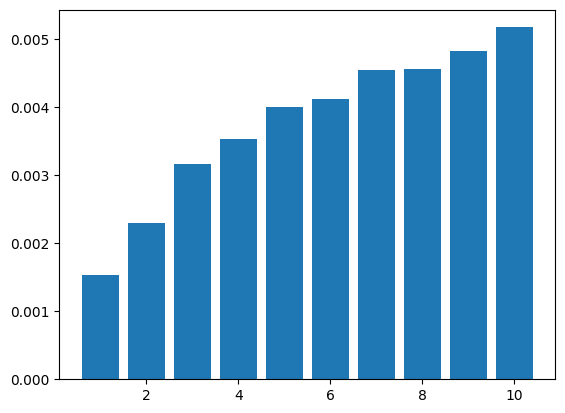

In [26]:
# No of spheres vs error

from collections import defaultdict
import matplotlib.pyplot as plt

err_nk = defaultdict(list)

for i in range(len(err)):
    nk = int(val_dist_tensor[i, -10:].sum().item())
    err_nk[nk].append(torch.sqrt(err[i].mean()).item())

for nk in err_nk:
    err_nk[nk] = sum(err_nk[nk])/len(err_nk[nk])

err_nk = sorted(err_nk.items())
plt.bar([x[0] for x in err_nk], [x[1] for x in err_nk]);

In [27]:
err_nk

[(1, 0.0015378093695457057),
 (2, 0.002293767604616288),
 (3, 0.003162344889942697),
 (4, 0.0035341756980067636),
 (5, 0.004002709433923065),
 (6, 0.004117278042488108),
 (7, 0.0045464700273745015),
 (8, 0.00455587785817199),
 (9, 0.004821915574411433),
 (10, 0.005172282500462258)]